# Car Price Prediction


### Problem Statement
Given data of US cars. We need to create model which predicts prices.

### Business Goal 

We also need to find top features that have higher correlation to price value. We aren't looking for complex dependencies. We need to consider all features separately with the target. 

# Imports

In [1]:
# to remove some user warnings from pandas and numpy
import warnings
warnings.filterwarnings('ignore')

# for numerical computations
import numpy as np
import pandas as pd

# for plotting and visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for training models, evaluations and feature processing
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate

# Helper Functions

In [2]:
def hist_plot(dataframe, features, rows, cols):
    fig = plt.figure(figsize=(20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins=20, ax=ax, facecolor='midnightblue')
        ax.set_title(feature+" Distribution", color='DarkRed')

    fig.tight_layout()
    plt.show()

In [3]:
def pie_plot(series, figsize=(7, 7)):
    ax_ = plt.figure(figsize=figsize).add_subplot()
    ax_.pie(series.value_counts(), labels=series.value_counts().index)

In [4]:
def corr_plot(dataframe, figsize=(10, 10)):
    axes_ = plt.figure(figsize=figsize).add_subplot()
    corr = dataframe.corr()
    ax = sns.heatmap(
        corr,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

In [5]:
def barh_plot(series, figsize=(10, 10)):
    ax_ = plt.figure(figsize=figsize).add_subplot()
    ax_.barh(series.index, series.values)

In [6]:
def top_correlated_features(dataframe, features=None, top_n=10):
    if not features:
        features = dataframe.columns
    
    data = {}
    for feature in features:
        if feature in dataframe.columns:
            data[feature] = dataframe[feature].value_counts().index.values[:top_n]
    
    return data

# Reading and Understanding the Data

Let's start with the following steps:

1. Importing data using the pandas library
2. Understanding the structure of the data

## Read Data

In [7]:
cars = pd.read_csv('data/workshop_1/CarPrice_Assignment.csv')
cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


## number of records

Since we have very low amount of records our model won't be as good as it should be in general. Anyway it's a example for demonstrating your skills on model selection, hyperparameter tuning and model selection/scoring 

In [8]:
cars.shape

(205, 26)

## Features

Names of these features are easy to understand

In [9]:
cars.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

## See top frequent values from each column

To get quick overview on values for each feature we can list top frequent values for each

In [10]:
show_top_unique_values(cars, top_n=5)

{'car_ID': array([205,  64,  74,  73,  72]),
 'symboling': array([ 0,  1,  2,  3, -1]),
 'CarName': array(['toyota corona', 'peugeot 504', 'toyota corolla', 'subaru dl',
        'mazda 626'], dtype=object),
 'fueltype': array(['gas', 'diesel'], dtype=object),
 'aspiration': array(['std', 'turbo'], dtype=object),
 'doornumber': array(['four', 'two'], dtype=object),
 'carbody': array(['sedan', 'hatchback', 'wagon', 'hardtop', 'convertible'],
       dtype=object),
 'drivewheel': array(['fwd', 'rwd', '4wd'], dtype=object),
 'enginelocation': array(['front', 'rear'], dtype=object),
 'wheelbase': array([94.5, 93.7, 95.7, 96.5, 98.4]),
 'carlength': array([157.3, 188.8, 166.3, 171.7, 186.7]),
 'carwidth': array([63.8, 66.5, 65.4, 63.6, 64.4]),
 'carheight': array([50.8, 52. , 55.7, 54.5, 54.1]),
 'curbweight': array([2385, 1989, 1918, 2275, 3230]),
 'enginetype': array(['ohc', 'ohcf', 'ohcv', 'dohc', 'l'], dtype=object),
 'cylindernumber': array(['four', 'six', 'five', 'eight', 'two'], dtype=

## List Numerical Features

If you check data types for each feature you can select numerical ones. It may happen that numerical values are in "Object" format if numbers are represented as strings, so please double check to make sure you got them correctly!

In [17]:
# find numerical features by checking their data type not equals to "object" 
numerical_features = cars.loc[:, cars.dtypes != np.object]
numerical_features

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,109.1,188.8,68.9,55.5,2952,141,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,109.1,188.8,68.8,55.5,3049,141,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,109.1,188.8,68.9,55.5,3012,173,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,109.1,188.8,68.9,55.5,3217,145,3.01,3.40,23.0,106,4800,26,27,22470.0


## We have not empty (NAN) values

In [16]:
# count number of nan's in total in data
nan_count = cars.shape[0] - cars.dropna().shape[0]
print(nan_count) 

0


# Data Preparation

## Take only numerical features

We only use numerical features for simplicity now. Usually all features are used considering their importance and correlation with target. Feature engineering will be taught later in separate lecture. You can get some examples from [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html)

In [23]:
# take only chosen numerical features and assign back to dataframe
numeric_columns = []
for col in numerical_features.columns:
    numeric_columns.append(col)
cars = cars[numeric_columns]
cars.head()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


# Visualizing the data


## Show target distribution

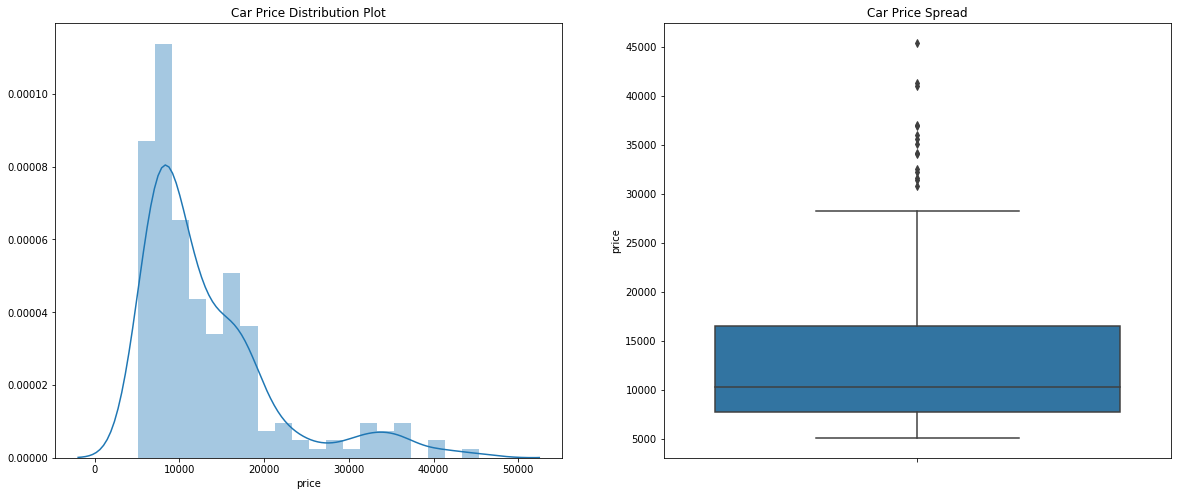

In [24]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(cars.price, bins=20)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=cars.price)

plt.show()

### Show some percentiles

In [25]:
print(cars.price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count      205.000000
mean     13276.710571
std       7988.852332
min       5118.000000
25%       7788.000000
50%      10295.000000
75%      16503.000000
85%      18500.000000
90%      22563.000000
100%     45400.000000
max      45400.000000
Name: price, dtype: float64


#### Inference :

1. The plot seemed to be right-skewed, meaning that the most prices in the dataset are low(Below 15,000).
2. There is a significant difference between the mean and the median of the price distribution.
3. The data points are far spread out from the mean, which indicates a high variance in the car prices.(85% of the prices are below 18,500, whereas the remaining 15% are between 18,500 and 45,400.)

## Visualising numerical data

### show histograms

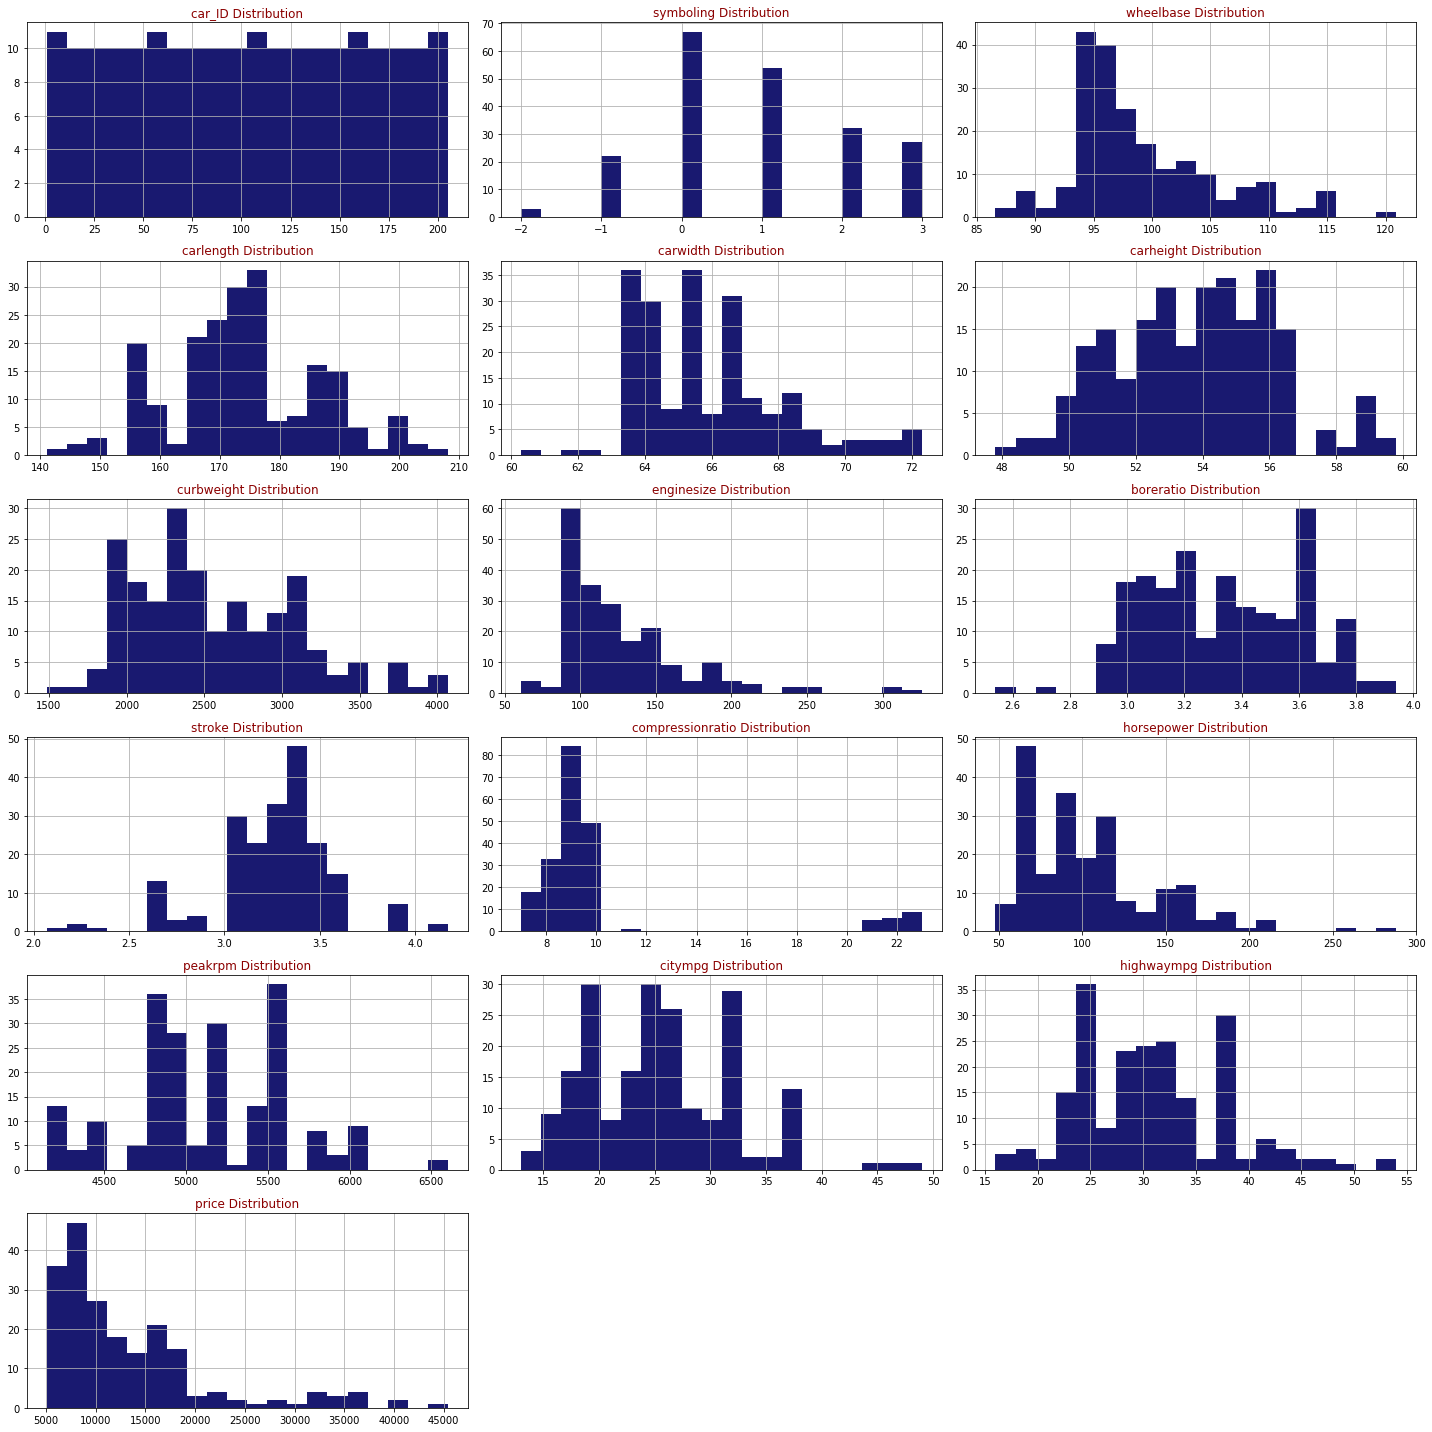

In [26]:
hist_plot(dataframe=cars, features=cars.columns, rows=6, cols=3)

## Look at main statistical properties

In [27]:
cars.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


## Show Feature PairWise Scatter Plots

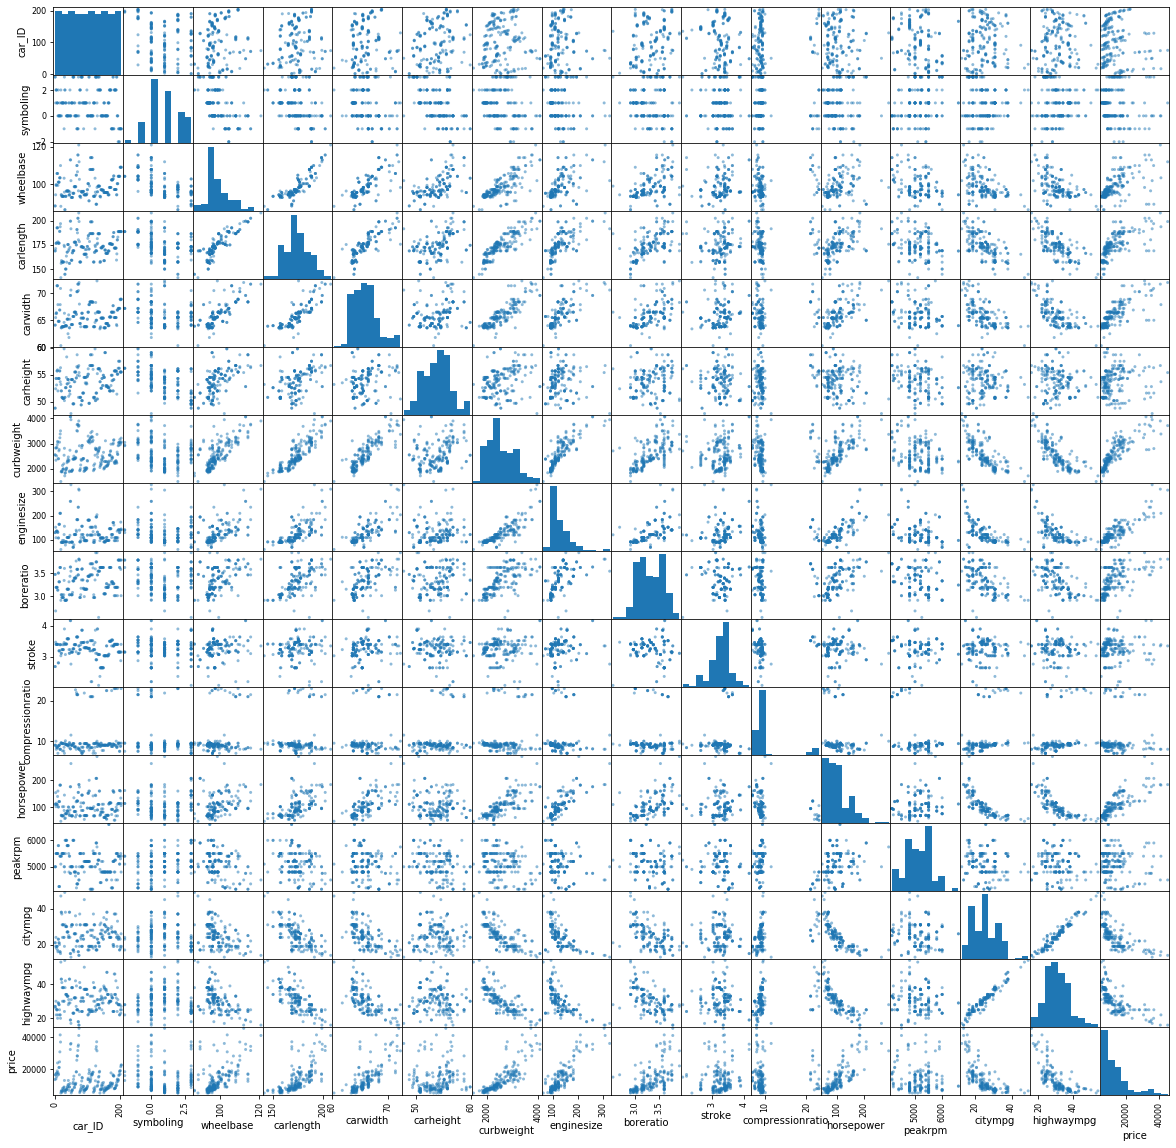

In [28]:
pd.plotting.scatter_matrix(cars, figsize=(20, 20));

## Show feature correlations

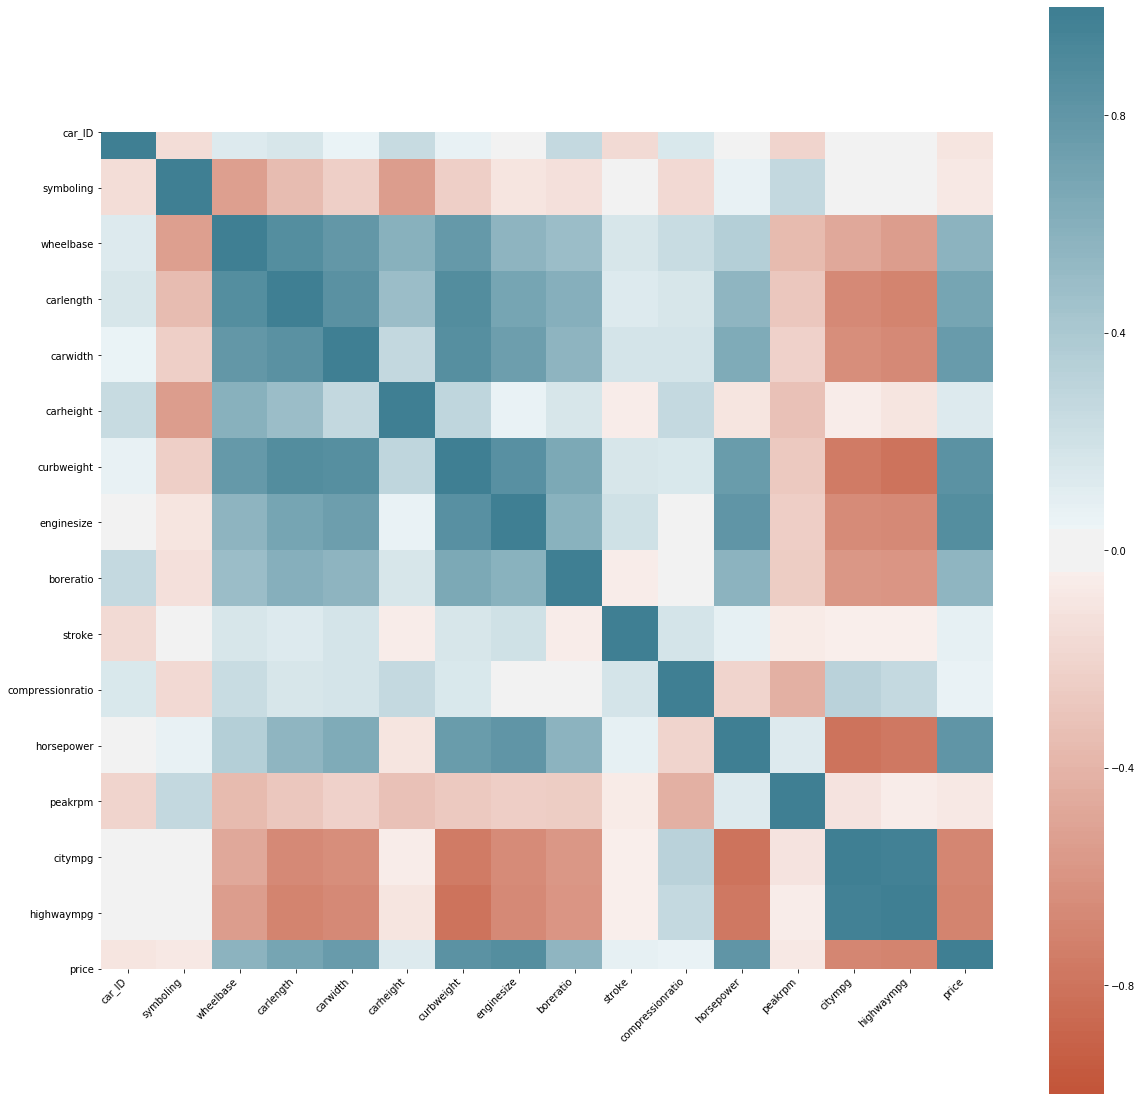

In [29]:
corr_plot(cars, figsize=(20,20))

## Show Features Correlations with Target sorted with absolute value

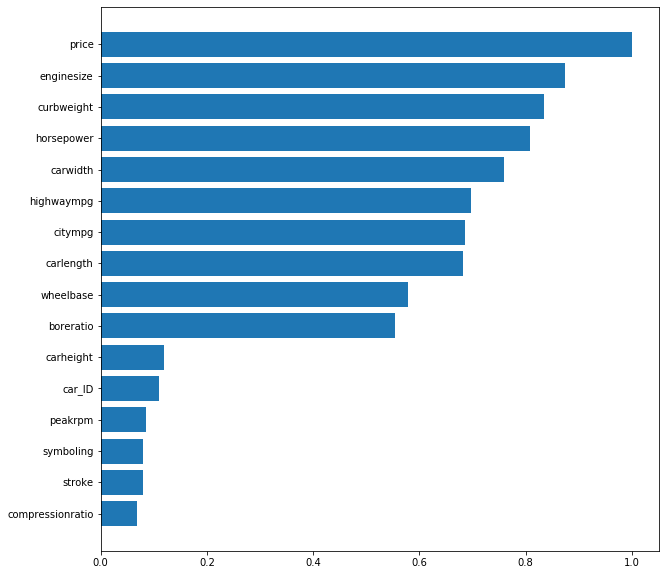

In [30]:
barh_plot(cars.corr()['price'].abs().sort_values(ascending=True))

In [32]:
correlations = cars.corr()['price'].abs().sort_values(ascending=False)
correlations

price               1.000000
enginesize          0.874145
curbweight          0.835305
horsepower          0.808139
carwidth            0.759325
highwaympg          0.697599
citympg             0.685751
carlength           0.682920
wheelbase           0.577816
boreratio           0.553173
carheight           0.119336
car_ID              0.109093
peakrpm             0.085267
symboling           0.079978
stroke              0.079443
compressionratio    0.067984
Name: price, dtype: float64

In [50]:
# take top correlated features with correlation more than 0.5
top_correlated_features = []

# Create correlation matrix
corr_matrix = cars.corr()['price'].abs()
for col in numeric_columns:
    if (corr_matrix[col] > 0.5):
        top_correlated_features.append(col)

top_correlated_features

['wheelbase',
 'carlength',
 'carwidth',
 'curbweight',
 'enginesize',
 'boreratio',
 'horsepower',
 'citympg',
 'highwaympg',
 'price']

## Take top correlated features and target only

In [52]:
# take only high correlated features + target and assign all of them to cars dataframe (overwrite)
cars = cars[top_correlated_features]
cars.head()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,price
0,88.6,168.8,64.1,2548,130,3.47,111,21,27,13495.0
1,88.6,168.8,64.1,2548,130,3.47,111,21,27,16500.0
2,94.5,171.2,65.5,2823,152,2.68,154,19,26,16500.0
3,99.8,176.6,66.2,2337,109,3.19,102,24,30,13950.0
4,99.4,176.6,66.4,2824,136,3.19,115,18,22,17450.0


## Show Pair Plot of top correlated features

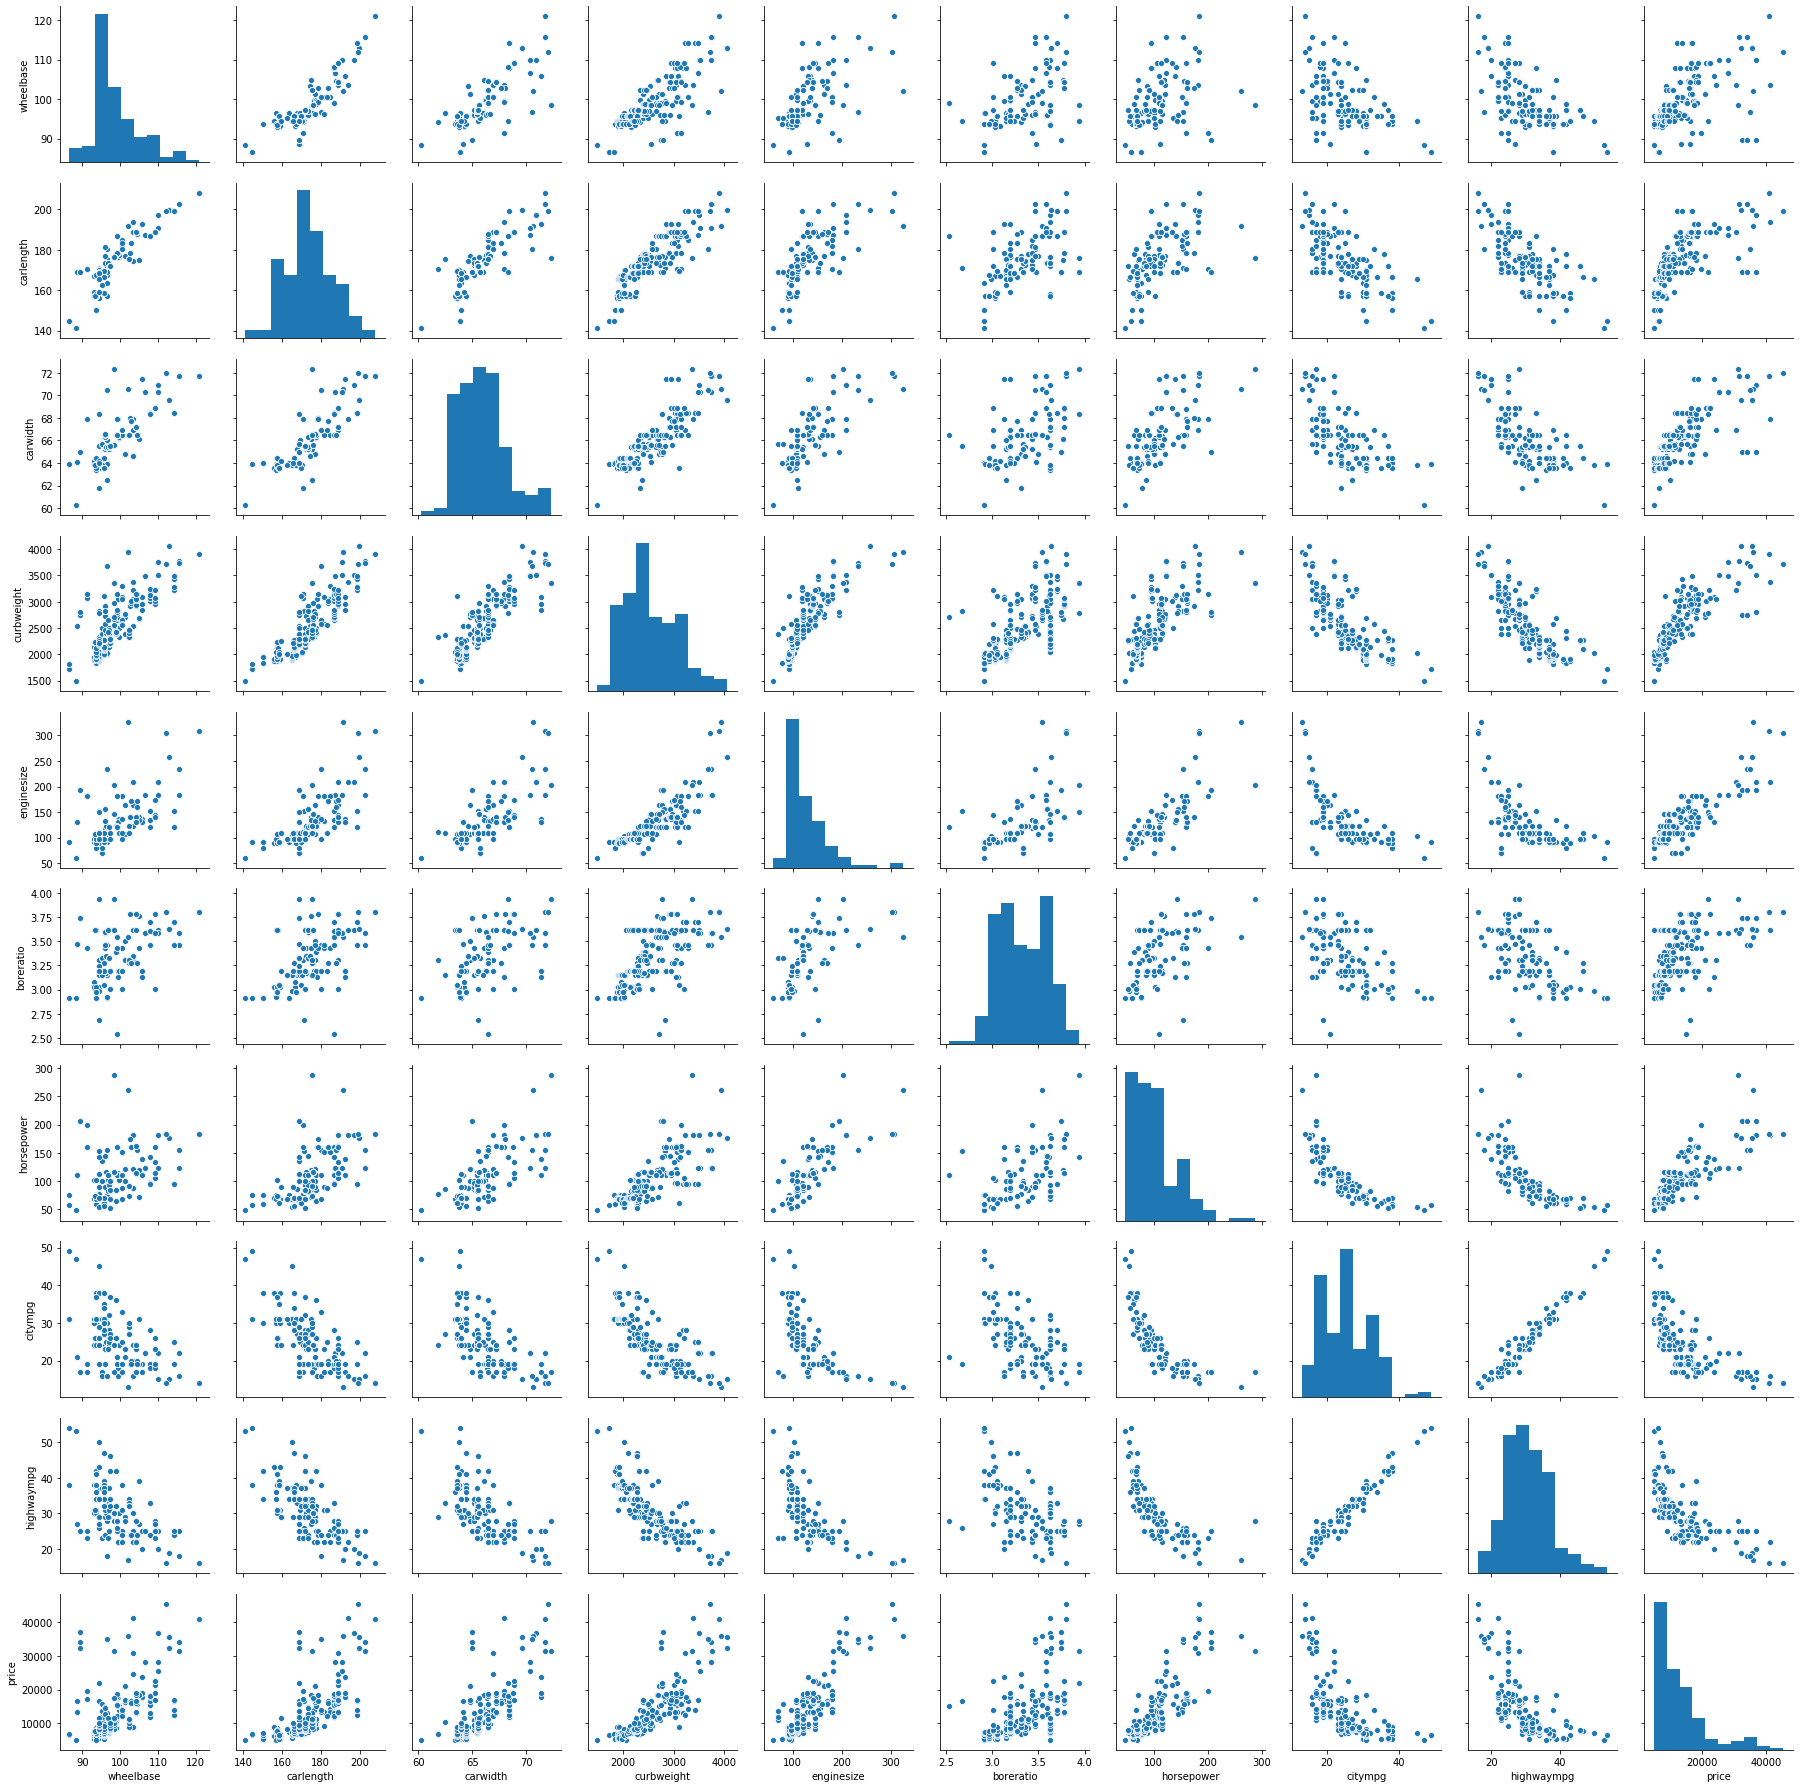

In [53]:
sns.pairplot(cars)
plt.show()

# Train-Test Split and feature scaling

## Split Data

In [54]:
RANDOM_SEED = 42
TEST_SIZE = 0.3

In [120]:
# split data into training and test parts using random seed, test size (here we don't use stratify since price is not binary)
df_train, df_test = train_test_split(cars, test_size=TEST_SIZE, random_state=RANDOM_SEED)

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,price
15,103.5,189.0,66.9,3230,209,3.62,182,16,22,30760.000
9,99.5,178.2,67.9,3053,131,3.13,160,16,22,17859.167
100,97.2,173.4,65.2,2302,120,3.33,97,27,34,9549.000
132,99.1,186.6,66.5,2658,121,3.54,110,21,28,11850.000
68,110.0,190.9,70.3,3750,183,3.58,123,22,25,28248.000
...,...,...,...,...,...,...,...,...,...,...
56,95.3,169.0,65.7,2380,70,3.33,101,17,23,11845.000
128,89.5,168.9,65.0,2800,194,3.74,207,17,25,37028.000
76,93.7,157.3,64.4,1918,92,2.97,68,37,41,5389.000
144,97.0,172.0,65.4,2385,108,3.62,82,24,25,9233.000


## Scale Features

Min-Max Scaler does the scaling of each feature into \[0,1\] range. That is the basic scaling function which could be used. You can explore variety of scalers [here](https://scikit-learn.org/stable/modules/preprocessing.html)

initialize scaler object

You can find MinMaxScaler [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) 

In [66]:
# creta min-max scaler object from scikit learn with default parameters.
scaler = MinMaxScaler()

list numerical features

In [122]:
# list numerical features again (including price since it's not binary)
numerical_features = top_correlated_features.copy()

fit scaler on training data and then transform it. Will will transform test data using fitted scaler. It's usually done like that to simulate unseen data processing where.

In [123]:
# fit and transform numerical features from training data using scaler object created above 
df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features].values)

In [125]:
# transform numerical features from test data using scaler object trained on training data 
df_test[numerical_features] = scaler.transform(df_test[numerical_features].values)

## Check how correlations changed using pair plot

If you compare that to the original one (without transformations) you will see that correlations are changed. We are doing feature scaling to speedup process of convergence on training. However, using good feature engineering and scaling you can increase the performance of model. We aren't doing that for now.

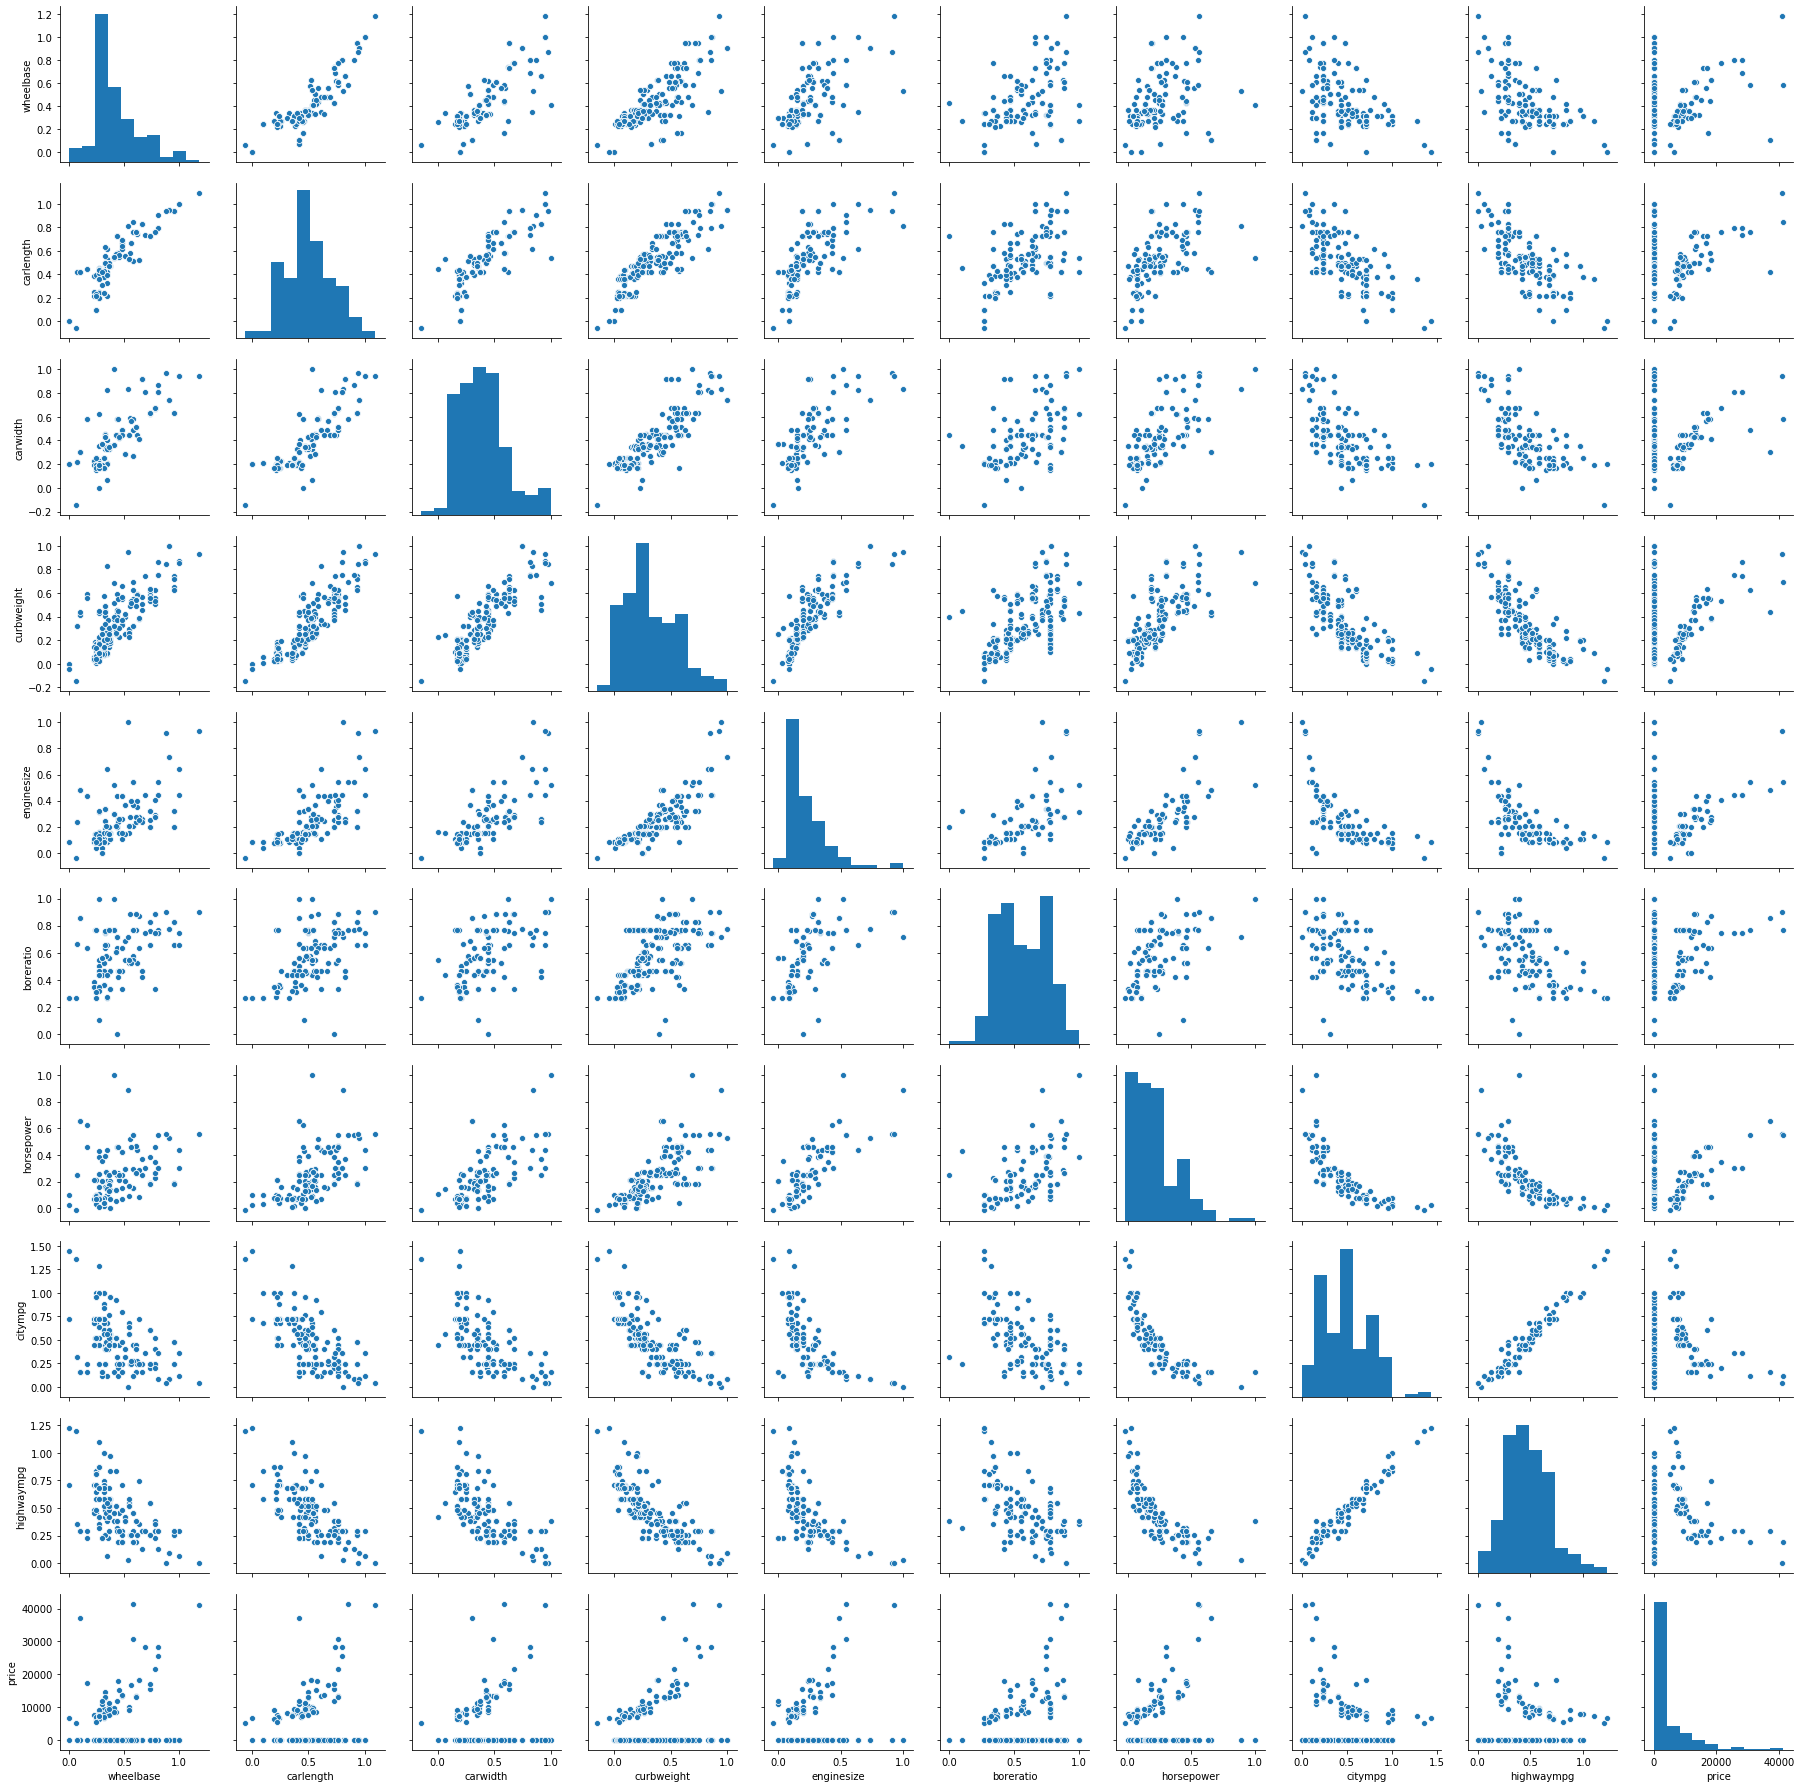

In [126]:
sns.pairplot(pd.concat([df_train, df_test], axis=0))
plt.show()

## Dividing data into X and y variables

In [133]:
# split all columns in training and test data into input features and target_feature 
input_features = numerical_features[:-1]
target_feature = numerical_features[-1]
input_features, target_feature

(['wheelbase',
  'carlength',
  'carwidth',
  'curbweight',
  'enginesize',
  'boreratio',
  'horsepower',
  'citympg',
  'highwaympg'],
 'price')

In [134]:
# separate input features and target for training data
y_train = df_train.iloc[:, -1]
X_train = df_train.iloc[:, :-1] 

In [135]:
# separate input features and target for test data
y_test = df_test.iloc[:, -1]
X_test = df_test.iloc[:, :-1] 

# Linear Regression

Linear regression is a type of regression analysis in statistics used for prediction of outcome of a numerical dependent variable from a set of predictor or independent variables. 

[Linear Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

## Create Linear Regression Model

### Init Model

In [136]:
# create linear regression model
model = LinearRegression()

### Create Scoring for cross validation

In [137]:
# create scoring parameter with mean squared error measure named as "mse"
SCORING = {
    'r2',
    'neg_mean_squared_error'
}
CV = 20

### Cross validate and get scores and models

In [146]:
# calculate cross validation scores of linear regression model on training data using scoring and cross validation.
# use return_estimator=True to get also all estimator models tried
scores = cross_validate(model, X_train, y_train, cv=CV,
                        scoring=SCORING, return_estimator=True, 
                        return_train_score=True)

since we don't have Hyperparameters to tune for linear regression all the models are same and scores actually describe the how hard is each split to fit by linear hyperplane.

In [147]:
sorted(scores.keys())

['estimator',
 'fit_time',
 'score_time',
 'test_neg_mean_squared_error',
 'test_r2',
 'train_neg_mean_squared_error',
 'train_r2']

### Show Scores and models

In [157]:
# take out "estimator" and "test_mse" from scores data 
all_models =  scores['estimator']
all_scores = scores['test_neg_mean_squared_error']

In [158]:
all_models, all_scores

((LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  Li

### Check Scores Histogram

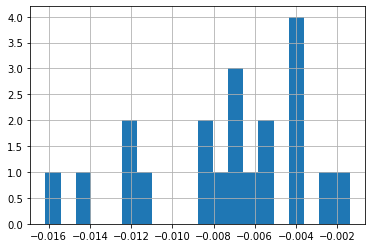

In [159]:
pd.Series(all_scores).hist(bins=20);

As we said we don't have any chance to find best model

### Choose one model

In [184]:
# get "Best" model from all models with lowest mse score
best_model = all_models[all_scores.argmin()]

### Do prediction on training data

In [188]:
# predict on training data using best model
y_train_pred = best_model.predict(X_train)
y_train_pred

array([ 1.88101473e-01,  3.53108993e-01,  1.47677585e-01,  3.69625250e-02,
        2.77514077e-01,  4.86002228e-02,  3.41173830e-01,  1.59797673e-01,
        4.94005939e-02,  2.52256053e-01,  8.01345194e-02,  2.70852494e-02,
        2.78048243e-01,  1.00013773e-01,  1.51457908e-01,  3.21837753e-01,
        4.30531721e-02,  9.62271485e-02,  2.46479927e-02,  2.54155294e-01,
        3.14064367e-01,  3.35317790e-01,  3.21621630e-01,  4.01312624e-02,
        1.67051632e-01,  3.84589416e-02,  4.03395879e-01,  1.52424017e-01,
        2.19442196e-02,  5.41777368e-02,  3.38261600e-01,  1.70377793e-01,
        1.91450629e-02,  2.05743454e-01,  1.16469740e-01,  5.77811059e-02,
        1.27896498e-01,  3.17370064e-01,  4.85886181e-02,  3.70075509e-01,
        9.92951537e-02,  4.03395879e-01,  2.68129644e-01,  8.68417712e-02,
        2.78356487e-01, -1.05444669e-02,  2.76876875e-01,  6.54277449e-02,
        2.76458140e-01,  1.24266937e-01,  1.27896498e-01,  1.71595255e-01,
        9.59836027e-03,  

### show error terms distribution

let's check how error terms are distributed. If it's close to normal distribution, it can mean that hyperplane is well fitted to our data

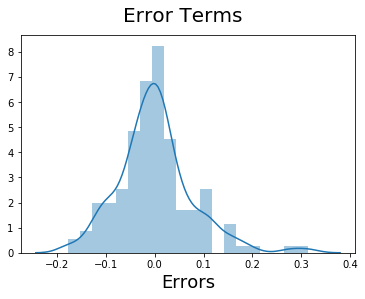

In [189]:
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20) 
plt.xlabel('Errors', fontsize = 18); 

Error terms seem to be approximately normally distributed, so the assumption on the linear modeling seems to be fulfilled.

# Prediction and Evaluation

## predict on test data

In [190]:
# predict on test data using best model
y_test_pred = best_model.predict(X_test)

## MSE and R2

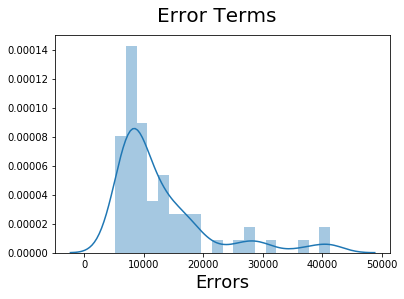

In [192]:
fig = plt.figure()
sns.distplot((y_test - y_test_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20) 
plt.xlabel('Errors', fontsize = 18); 

In [197]:
# calculate and print "mse" and "r2" scores for test data predictions (hint: use imported metrics from sklearn.metrics)
import sklearn.metrics as metrics

mse = metrics.mean_squared_error(y_test, y_test_pred)
r2 = metrics.r2_score(y_test, y_test_pred)

mse, r2

(237568799.43212205, -2.4288941344918564)

## Plotting y_test and y_test_pred to understand the spread

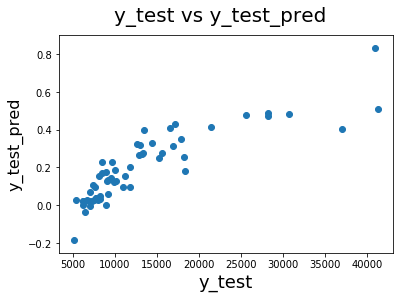

In [198]:
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize=20) 
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_test_pred', fontsize=16); 